# Attenuator Pads

> Graham M0YCX
>
> Ref: https://www.everythingrf.com/rf-calculators/attenuator-calculator

----
## Tee Attenuator

$$
R1 = Z_o \left[ \frac{10^{\frac{dB}{20}}-1}{10^{\frac{dB}{20}}+1} \right] \Omega
$$

$$
R2 = 2 Z_o \left[ \frac{10^{\frac{dB}{20}}}{10^{\frac{dB}{10}}-1} \right] \Omega
$$

----

## PI ($\pi$) Attenuator

$$
R1 = Z_o \left[ \frac{10^{\frac{dB}{20}}+1}{10^{\frac{dB}{20}}-1} \right]
$$

$$
R2 = \frac{Z_o}{2} \left[ \frac{10^{\frac{dB}{10}}-1}{10^{\frac{dB}{20}}} \right]
$$

In [1]:
import math

import pint

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import schemdraw as schem
import schemdraw.elements as e
from eseries import E12, E24, E48, find_nearest
from schemdraw import dsp

ureg = pint.UnitRegistry()

schem.use("svg")


def tee_attenuator(Zo, att_db, Pin, nearest):
    R1 = Zo * ((10.0 ** (att_db / 20.0) - 1.0) / (10.0 ** (att_db / 20.0) + 1))
    R2 = 2 * Zo * ((10.0 ** (att_db / 20.0)) / (10.0 ** (att_db / 10.0) - 1))
    RL = Zo

    if nearest != 0:
        R1 = find_nearest(nearest, R1)
        R2 = find_nearest(nearest, R2)

    Vin = math.sqrt(Pin * Zo)

    R1_RL = R1 + RL
    R2_R1_RL = 1 / (1 / R2 + 1 / R1_RL)
    R1_R2_R1_RL = R1 + R2_R1_RL

    # Potential divider R1 vs R2_R1_RL
    Vout1 = Vin * (R2_R1_RL / (R1 + R2_R1_RL))
    V1_R1 = Vin - Vout1
    P1_R1 = (V1_R1**2) / R1
    P_R2 = (Vout1**2) / R2
    P_R1_RL = (Vout1**2) / R1_RL
    Vout2 = Vout1 * (RL / (R1 + RL))
    V2_R1 = Vout1 - Vout2
    P2_R1 = (V2_R1**2) / R1
    P_RL = (Vout2**2) / RL

    # Proof
    Pin_att_db = Pin * 10 ** (-att_db / 10)
    if not math.isclose(P_RL, Pin_att_db, rel_tol=0.05):  # tolerance=5%
        print(
            f"WARNING: Power in RL is not within 5% tolerance: difference is {((P_RL-Pin_att_db) * ureg.watt):.2f~#P}"
        )

    d = schem.Drawing()

    d += e.Dot(open=True).label(f"Zo: {(Zo * ureg.ohm):.1f~#P}", loc="bot", color="red")
    d.push()

    d += e.Line().length(1).left()
    d += e.Line().length(1).down()
    d += (
        e.SourceSin()
        .label(f"Pwr in:\n{(Pin * ureg.watt):.1f~#P}", color="red")
        .down()
        .length(1)
    )
    d += e.Line().length(1).down()
    d += e.Ground()

    d.pop()
    d += e.Resistor(color="blue").label(
        f"R1\n{(R1 * ureg.ohm):.2f~#P}\n{(P1_R1 * ureg.watt):.2f~#P}", color="blue"
    )
    d += e.Dot()
    d.push()
    d += (
        e.Resistor(color="blue")
        .down()
        .label(
            f"R2\n{(R2 * ureg.ohm):.2f~#P}\n{(P_R2 * ureg.watt):.2f~#P}", color="blue"
        )
    )
    d += e.Ground()
    d.pop()
    d += e.Resistor(color="blue").label(
        f"R1\n{(R1 * ureg.ohm):.2f~#P}\n{(P2_R1 * ureg.watt):.2f~#P}", color="blue"
    )
    d += e.Dot(open=True).label(f"-{att_db} dB", loc="bot", color="red")

    d += e.Line().length(1).right()
    d += (
        e.Resistor()
        .label(
            f"RL\n{(Zo * ureg.ohm):.1f~#P}\n{(P_RL * ureg.watt):.2f~#P}", color="blue"
        )
        .down()
    )
    d += e.Ground()
    return d


def pi_attenuator(Zo, att_db, Pin, nearest):
    R1 = Zo * (((10 ** (att_db / 20)) + 1) / ((10 ** (att_db / 20)) - 1))
    R2 = (Zo / 2) * (((10 ** (att_db / 10)) - 1) / (10 ** (att_db / 20)))
    RL = Zo

    if nearest != 0:
        R1 = find_nearest(nearest, R1)
        R2 = find_nearest(nearest, R2)

    Vin = math.sqrt(Pin * Zo)
    P1_R1 = (Vin**2) / R1
    R1_RL = 1 / ((1 / R1) + (1 / RL))
    Vout1 = Vin * (R1_RL / (R2 + R1_RL))
    V_R2 = Vin - Vout1
    P_R2 = (V_R2**2) / R2

    P2_R1 = (Vout1**2) / R1
    P_RL = (Vout1**2) / RL

    # Proof
    Pin_att_db = Pin * 10 ** (-att_db / 10)
    if not math.isclose(P_RL, Pin_att_db, rel_tol=0.05):  # tolerance=5%
        print(
            f"WARNING: Power in RL is not within 5% tolerance: difference is {((P_RL-Pin_att_db) * ureg.watt):.2f~#P}"
        )

    d = schem.Drawing()
    d += e.Dot(open=True).label(f"Zo: {(Zo * ureg.ohm):.1f~#P}", loc="bot", color="red")
    d.push()

    d += e.Line().length(1).left()
    d += e.Line().length(1).down()
    d += (
        e.SourceSin()
        .label(f"Pwr in:\n{(Pin * ureg.watt):.1f~#P}", color="red")
        .down()
        .length(1)
    )
    d += e.Line().length(1).down()
    d += e.Ground()

    d.pop()
    d += e.Line().length(1.5)
    d += e.Dot()
    d.push()
    d += (
        e.Resistor(color="blue")
        .down()
        .label(
            f"R1\n{(R1 * ureg.ohm):.2f~#P}\n{(P1_R1 * ureg.watt):.2f~#P}", color="blue"
        )
    )
    d += e.Ground()
    d.pop()
    d += e.Resistor(color="blue").label(
        f"R2\n{(R2 * ureg.ohm):.2f~#P}\n{(P_R2 * ureg.watt):.2f~#P}", color="blue"
    )
    d += e.Dot()
    d.push()
    d += (
        e.Resistor(color="blue")
        .down()
        .label(
            f"R1\n{(R1 * ureg.ohm):.2f~#P}\n{(P2_R1 * ureg.watt):.2f~#P}", color="blue"
        )
    )
    d += e.Ground()
    d.pop()
    d += e.Line().length(1.5)
    d += e.Dot(open=True).label(f"-{att_db} dB", loc="bot", color="red")

    d += e.Line().length(1).right()
    d += (
        e.Resistor()
        .label(
            f"RL\n{(Zo * ureg.ohm):.1f~#P}\n{(P_RL * ureg.watt):.2f~#P}", color="blue"
        )
        .down()
    )
    d += e.Ground()
    return d

In [2]:
####################################
# Select your pad requirements here
Zo = 50  # 50
att_db = 10
Pin = 100
nearest = E24

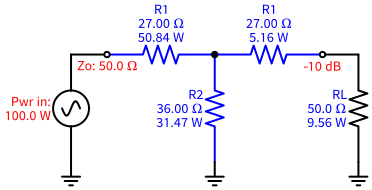

In [5]:
tee_attenuator(Zo, att_db, Pin, nearest).draw()

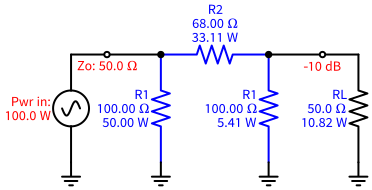

In [6]:
pi_attenuator(Zo, att_db, Pin, nearest).draw()